In [1]:
import pandas as pd
import xarray as xr

import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Polygon, mapping
import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import plotting_extent
import regionmask
import xesmf as xe

import sys
sys.path.append('../')
import utils
import plotting

import math

Using raster = 4 to get the 2015 GWP population density

## Import Pollution Dataset

In [3]:
#### import our pollution datasets ####
poll_ds = xr.open_zarr("./data/nonuc_normal_GC.zarr/")

lonb = poll_ds['lon'].values + (poll_ds['lon'][0]-poll_ds['lon'][1]).values/2
lonb = np.append(lonb, (lonb[-1] - (poll_ds['lon'][0]-poll_ds['lon'][1]).values))

latb = poll_ds['lat'].values + (poll_ds['lat'][0]-poll_ds['lat'][1]).values/2
latb = np.append(latb, (latb[-1] - (poll_ds['lat'][0]-poll_ds['lat'][1]).values))

In [4]:
lat_dif = .5
lat = np.arange(-90.,90.,lat_dif)
lat[0] = -90.+lat_dif/2
lat[-1] = 90.-lat_dif/2
lat_b = lat+lat_dif/2
lat_b = np.insert(lat_b, 0, -90)
#lat_b = np.append(lat_b, 90)

lon_dif = .625
lon = np.arange(-180.,180.,lon_dif)
lon_b = lon+lon_dif/2
lon_b = np.insert(lon_b, 0, -180)
lon_b = np.append(lon_b, 180)

## Import Population Density and Land Area Datasets

In [5]:
#### import our dataset for population density ####
ds = xr.open_dataset("/net/fs11/d0/emfreese/population_data/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_adjusted_rev11_2pt5_min.nc")
pop_ds = ds.sel(raster = 4) #density in persons / sq km
pop_ds = pop_ds.rename({'latitude':'lat', 'longitude':'lon'})

pop_ds = pop_ds.assign_coords(coords = {'lat':pop_ds['lat']}) #fix the lat
pop_ds = pop_ds.fillna(0) 
pop_ds = pop_ds.rename({'UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes':'pop_density'})

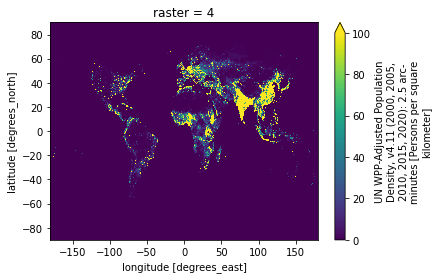

In [6]:
pop_ds['pop_density'].plot.imshow(vmax = 100)

In [7]:
#### import our dataset for land area ####
ds = xr.open_dataset("/net/fs11/d0/emfreese/population_data/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_adjusted_rev11_2pt5_min.nc")
land_ds = ds.sel(raster = 9) #density in persons / sq km
land_ds = land_ds.rename({'latitude':'lat', 'longitude':'lon'})

land_ds = land_ds.assign_coords(coords = {'lat':land_ds['lat']}) #fix the lat
land_ds = land_ds.fillna(0) 
land_ds = land_ds.rename({'UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes':'land_area'})

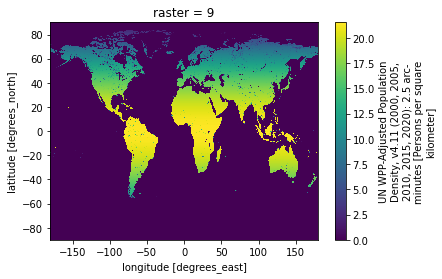

In [8]:
land_ds['land_area'].plot.imshow()

## Merge Land and Population Datasets, Calculate Total Area

In [9]:
#### merge our pop and land area datasets ####
land_pop_ds = xr.merge([pop_ds, land_ds], compat='override')

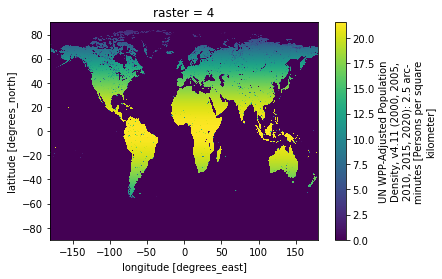

In [10]:
land_pop_ds['land_area'].plot.imshow()

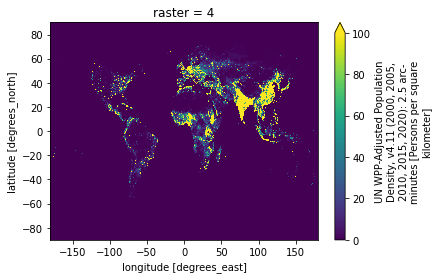

In [11]:
land_pop_ds['pop_density'].plot.imshow(vmax = 100)

In [12]:
#### create lat and lon bounds ####
lonb = land_pop_ds['lon'].values + (land_pop_ds['lon'][0]-land_pop_ds['lon'][1]).values/2
lonb = np.append(lonb, (lonb[-1] - (land_pop_ds['lon'][0]-land_pop_ds['lon'][1]).values))

latb = land_pop_ds['lat'].values + (land_pop_ds['lat'][0]-land_pop_ds['lat'][1]).values/2
latb = np.append(latb, (latb[-1] - (land_pop_ds['lat'][0]-land_pop_ds['lat'][1]).values))

land_pop_ds['lon_b'] = lonb
land_pop_ds['lat_b'] = latb

In [31]:
#### function to find area of a grid cell from lat/lon ####
def find_area(ds, R = 6378.1):
    """ ds is the dataset, i is the number of longitudes to assess, j is the number of latitudes, and R is the radius of the earth in km. 
    Must have the ds['lat'] in descending order (90...-90)
    Returns Area of Grid cell in km"""
    
    dy = (ds['lat_b']- ds['lat_b'].roll({'lat_b':-1}, roll_coords = False))[:-1]*2*np.pi*R/360 

    dx1 = (ds['lon_b'].roll({'lon_b':-1}, roll_coords = False) - 
           ds['lon_b'])[:-1]*2*np.pi*R*np.cos(np.deg2rad(ds['lat_b']))
    
    dx2 = (ds['lon_b'].roll({'lon_b':-1}, roll_coords = False) - 
           ds['lon_b'])[:-1]*2*np.pi*R*np.cos(np.deg2rad(ds['lat_b'].roll({'lat_b':-1}, roll_coords = False)[:-1]))
    
    A = .5*(dx1+dx2)*dy
    
    #### assign new lat and lon coords based on the center of the grid box instead of edges ####
    A = A.assign_coords(lon_b = ds.lon.values,
                    lat_b = ds.lat.values)
    A = A.rename({'lon_b':'lon','lat_b':'lat'})

    A = A.transpose()
    
    return(A)

In [32]:
#### find the area of our original grid cells ####
A = find_area(land_pop_ds)



In [33]:
#### merge to create a new ds with all of our original land and population data ####
orig_ds = xr.merge([land_pop_ds, A.to_dataset(name = 'orig_total_area')])

orig_ds['land_area_ratio'] = orig_ds['land_area']/orig_ds['orig_total_area']
orig_ds['orig_pop_count'] = orig_ds['pop_density']* orig_ds['land_area']


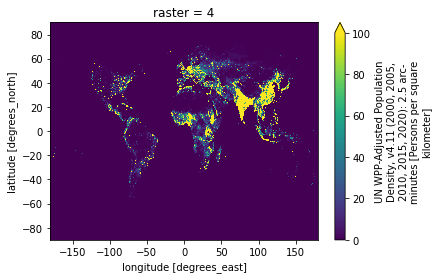

In [34]:
orig_ds['pop_density'].plot.imshow(vmax = 100)

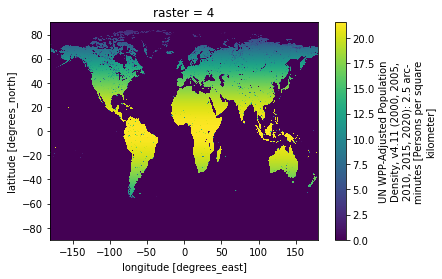

In [17]:
orig_ds['land_area'].plot.imshow()

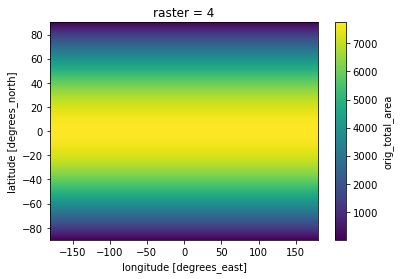

In [18]:
orig_ds['orig_total_area'].plot.imshow()

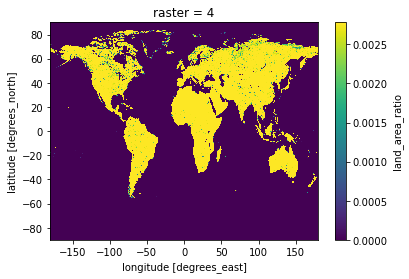

In [19]:
orig_ds['land_area_ratio'].plot.imshow()

## Regrid our dataset

In [20]:
def make_2d_grid(lon_b1, lon_b2, lon_step, lat_b1, lat_b2, lat_step):
    lon_bounds = np.arange(lon_b1, lon_b2+lon_step, lon_step)
    lon_centers = (lon_bounds[:-1] + lon_bounds[1:])/2
    
    lat_bounds = np.arange(lat_b1, lat_b2+lat_step, lat_step)[::-1]
    lat_centers = (lat_bounds[:-1] + lat_bounds[1:])/2
    
    ds = xr.Dataset({'lat': (['lat'], lat_centers),
                     'lon': (['lon'], lon_centers),
                     'lat_b': (['lat_b'], lat_bounds),
                     'lon_b': (['lon_b'], lon_bounds),
                    }
                   )
    return(ds)

In [21]:
#make a ds with grid for output and grid for input 
ds_out = make_2d_grid(-180, 180, lon_dif, 90, -90, -lat_dif) #grid that we want to regrid to
ds_in = make_2d_grid(-180, 180, .041666667, -90, 90, .041666667) #same as the grid for orig_ds

In [22]:
#create regridder (reusing weights)
regridder = xe.Regridder(ds_in, ds_out, 'conservative', reuse_weights = True)
regridder  # print basic regridder information.

#regrid according to our ds_out grid
regrid_ds = regridder(orig_ds)

#update the latb and lonb so that they match the ds_out values
regrid_ds['lon_b'] = ds_out['lon_b']
regrid_ds['lat_b'] = ds_out['lat_b']

regrid_ds #look at our regridded dataset

/home/emfreese/anaconda3/envs/grid_model/lib/python3.8/site-packages/xesmf/backend.py:52: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn("Latitude is outside of [-90, 90]")


Reuse existing file: conservative_4320x8640_360x576.nc
using dimensions ('lat', 'lon') from data variable pop_density as the horizontal dimensions for this dataset.


/home/emfreese/anaconda3/envs/grid_model/lib/python3.8/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


<xarray.Dataset>
Dimensions:          (lat: 360, lat_b: 361, lon: 576, lon_b: 577)
Coordinates:
    raster           int32 4
  * lon_b            (lon_b) float64 -180.0 -179.4 -178.8 ... 178.8 179.4 180.0
  * lat_b            (lat_b) float64 -90.0 -89.5 -89.0 -88.5 ... 89.0 89.5 90.0
  * lon              (lon) float64 -179.7 -179.1 -178.4 ... 178.4 179.1 179.7
  * lat              (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
Data variables:
    pop_density      (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    land_area        (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    orig_total_area  (lat, lon) float64 44.98 44.98 44.98 ... 44.98 44.98 44.98
    land_area_ratio  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    orig_pop_count   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  conservative

In [35]:
#### find the area of our original grid cells ####
A = find_area(regrid_ds)

Area_ds = A.to_dataset(name = 'regrid_total_area')
Area_ds = Area_ds*-1

regrid_area_ds = xr.merge([regrid_ds, Area_ds])
regrid_area_ds = regrid_area_ds.drop(['orig_pop_count', 'land_area', 'orig_total_area'])

In [36]:
#### create new variables in regridded ds ####

regrid_area_ds['regrid_land_area'] = regrid_area_ds['land_area_ratio'] * regrid_area_ds['regrid_total_area'] 

regrid_area_ds['regrid_pop_count'] = regrid_area_ds['regrid_land_area'] * regrid_area_ds['pop_density']

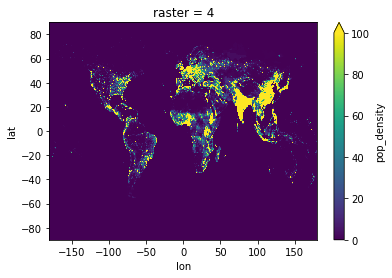

In [37]:
regrid_area_ds['pop_density'].plot.imshow(vmax = 100)

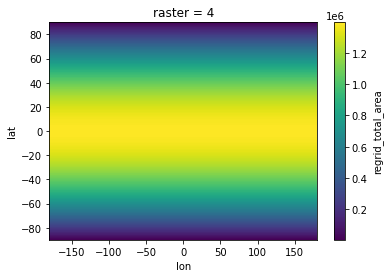

In [38]:
regrid_area_ds['regrid_total_area'].plot.imshow()

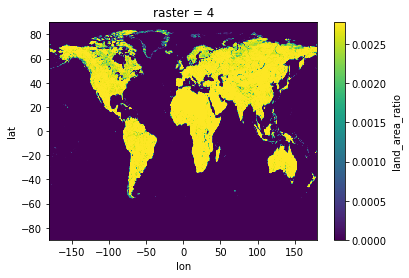

In [27]:
regrid_area_ds['land_area_ratio'].plot.imshow()

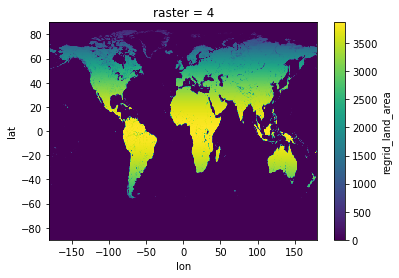

In [28]:
regrid_area_ds['regrid_land_area'].plot.imshow()

In [29]:
#### check that we still have ~7 billion population ####
print(regrid_area_ds['regrid_pop_count'].sum(), orig_ds['orig_pop_count'].sum())

<xarray.DataArray 'regrid_pop_count' ()>
array(7.00856261e+09)
Coordinates:
    raster   int32 4 <xarray.DataArray 'orig_pop_count' ()>
array(7.3493243e+09, dtype=float32)
Coordinates:
    raster   int32 4


## Mask our data to just the United States

In [30]:
#### create a mask ####
states = regionmask.defined_regions.natural_earth.us_states_50
lon = np.arange(230, 300, .25)
lat = np.arange(50, 24, -.125)
mask = states.mask(regrid_area_ds, lon_name = 'lon', lat_name = 'lat')
contiguous_mask = ~np.isnan(mask) & (mask != 0.) & (mask != 11) 

#### mask our population dataset ####
US_land_pop_ds = regrid_area_ds.where(contiguous_mask)

#### mask our pollution dataset ####
US_poll_ds = poll_ds.where(contiguous_mask)

total US population 294193664.8137231


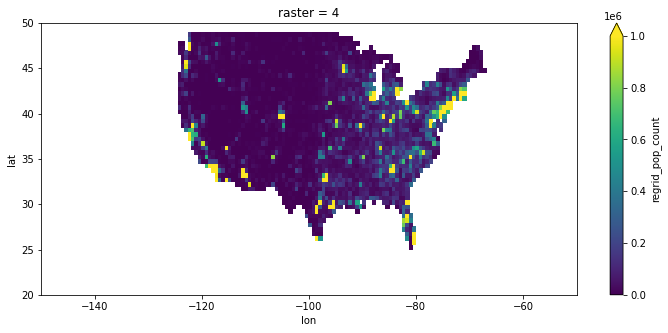

In [26]:
US_land_pop_ds['regrid_pop_count'].plot(figsize = (12,5), vmax = 1000000)
plt.xlim(-150,-50)
plt.ylim(20,50)
print('total US population', US_land_pop_ds['regrid_pop_count'].sum().values)

## 

## CRF

In [80]:
#### import our observational data #####

#mortality data from IHME GBD 2017
obs_mortality = pd.read_csv('../../health_data/global_burden_disease_2017_data/IHME-GBD_2017_DATA-2c4a32b7-1.csv')
obs_mortality = obs_mortality.drop([1,2,3,4,5])

#concentration data from van Donkelaar 2019 http://fizz.phys.dal.ca/~atmos/martin/?page_id=140 (replace with Di et al)
obs_concentration = xr.open_dataset('../../health_data/concentration_data/GWRwSPEC.HEI.ELEVandURB_PM25_NA_201601_201612-RH35.nc')

In [81]:
obs_concentration = obs_concentration.rename({'PM25':'chi_obs_PM25'})

In [82]:
I_obs = np.full((len(obs_ds['LAT']), len(obs_ds['LON'])), obs_mortality['val'])

In [83]:
I_obs_ds = xr.DataArray(I_obs, 
             dims=('LAT', 'LON'),
             coords = {'LAT':obs_ds['LAT'].values, 'LON':obs_ds['LON'].values},
            name = 'I_obs')

In [85]:
obs_ds = xr.merge((I_obs_ds, obs_concentration))

In [86]:
obs_ds

<xarray.Dataset>
Dimensions:       (LAT: 4550, LON: 9300)
Coordinates:
  * LAT           (LAT) float64 68.0 67.99 67.97 67.96 ... 22.52 22.51 22.5
  * LON           (LON) float64 -138.0 -138.0 -138.0 ... -45.03 -45.01 -45.01
Data variables:
    I_obs         (LAT, LON) float64 2.794e+06 2.794e+06 ... 2.794e+06 2.794e+06
    chi_obs_PM25  (LAT, LON) float32 ...